In [1]:
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, Input, Activation, Reshape, Flatten
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from ImageUtils import ImageUtils
import pickle
from keras.utils import plot_model

D:\sf\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
#基本常量
sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimages'
targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimagesResize320L'
root = 'D:/jupyter/car-management/recognitionalgorithm/dataset'
Xfilename = 'licenseplateL_1_1.npy'
Yfilename = 'labe_l_1.npy'
filename = '字典.xlsx'

In [8]:
'''数据处理工具类'''
utils = ImageUtils()

In [7]:
utils.processImage(sourceFolder, targetFolder)

In [12]:
'''处理数据'''
X = utils.readXData(targetFolder)
Y = utils.readYData(root, targetFolder, filename)
utils.save(root, Xfilename, Yfilename, X, Y)

x's shape: (1222, 320, 320)
y's shape: (1222, 7)
冀A22222


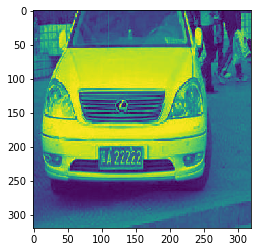

In [11]:
'''加载处理的数据'''
X_train, Y_train = utils.load(root, Xfilename, Yfilename)
print("x's shape: " + str(X_train.shape))
print("y's shape: " + str(Y_train.shape))
print(utils.getLabel(root, filename, Y_train[100]))
plt.imshow(X_train[100])

In [2]:
def inception_block(X, name, filters, strides):
    '''first layers'''
    f_skip_1, f_1_1, f_1_2, f_2_1, f_2_2, f_2_3 = filters 
    base_name = 'inception' + str(name)
    
    conv_1_1 = Conv2D(f_1_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    conv_1_2 = Conv2D(f_2_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_2', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    pool_1_1 = MaxPooling2D((3, 3), strides = strides, padding = 'same', name = base_name + '_p_1_1')(X)
    
    conv_skip_1 = Conv2D(f_skip_1, (1, 1), strides = 2 * strides, padding = 'same', name = base_name + '_skip_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    
    conv_2_1 = Conv2D(f_2_1, (3, 3), padding = 'same', strides = strides, name = base_name + '_c_2_1', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_1)
    conv_2_2 = Conv2D(f_2_2, (5, 5), padding = 'same', strides = strides, name = base_name + '_c_2_2', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_2)
    conv_2_3 = Conv2D(f_2_3, (1, 1), padding = 'same', strides =  strides, name = base_name + '_c_2_3', activation = 'relu', kernel_initializer = 'truncated_normal')(pool_1_1)
    
    # 合并
    inception = Concatenate(axis = -1, name = base_name + '_ct_1_1')([conv_skip_1, conv_2_1, conv_2_2, conv_2_3])
    
    return inception

In [7]:
'''测试'''
inputs_x = np.random.rand(1, 320, 320, 1)
inputs = Input(shape = (320, 320, 1))
outputs = inception_block(inputs, 1, (6, 6, 6, 6, 6, 6), strides = 2)
inception_model = Model(inputs = inputs, outputs = outputs)
inception_model.summary()
# y = inception_model.predict_on_batch(inputs_x)
y = inception_model.predict(inputs_x, batch_size = 1)
print(y.shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
inception1_c_1_1 (Conv2D)       (None, 160, 160, 6)  12          input_1[0][0]                    
__________________________________________________________________________________________________
inception1_c_1_2 (Conv2D)       (None, 160, 160, 6)  12          input_1[0][0]                    
__________________________________________________________________________________________________
inception1_p_1_1 (MaxPooling2D) (None, 160, 160, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
inception1

In [3]:
def identify_block(X, filters, name, strides):
    conv_name = 'identify_conv' + str(name)
    bn_name = 'identify_bn_name' + str(name)
    activation_name = 'identify_activation_name' + str(name)
    add_name = 'identify_add' + str(name)
    skip_name = 'identify_skip' + str(name)
    
    f_1_1, f_1_2, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (3, 3), strides = strides, padding = 'same', name = conv_name + '_1_1', kernel_initializer = 'truncated_normal')(X)
    bn_1_1 = BatchNormalization(name = bn_name + '_1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '_1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '_2_1', kernel_initializer = 'truncated_normal')(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '_2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '_2_1')(bn_2_1)
    
    '''skip unit'''
    skip_strides = 2 * strides
    if strides == 1:
        skip_strides = 1
        
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, padding = 'same', name = skip_name + '_1_1', kernel_initializer = 'truncated_normal')(X)
    
    identify = Add(name = add_name + '_1_1')([activation_2_1, conv_skip_1_1])
    
    return identify

In [26]:
inputs_x = np.random.rand(1, 320, 320, 1)
inputs = Input(shape = (320, 320, 1))
outputs = identify_block(inputs, filters = (3, 3, 3), name = '1', strides = 2)
identify_model = Model(inputs = inputs, outputs = outputs)
identify_y = identify_model.predict(inputs_x)
print(identify_y.shape)
identify_model.summary()

(1, 80, 80, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
identify_conv1_1_1 (Conv2D)     (None, 160, 160, 3)  30          input_6[0][0]                    
__________________________________________________________________________________________________
identify_bn_name1_1_1 (BatchNor (None, 160, 160, 3)  12          identify_conv1_1_1[0][0]         
__________________________________________________________________________________________________
identify_activation_name1_1_1 ( (None, 160, 160, 3)  0           identify_bn_name1_1_1[0][0]      
______________________________________________________________________________________________

In [16]:
'''build convlution block'''
def bottleneck_block(X, filters, name, strides):
    conv_name = 'bk_conv' + str(name)
    bn_name = 'bk_bn' + str(name)
    activation_name = 'bk_an' + str(name)
    add_name = 'bk_add' + str(name)
    skip_name = 'bk_sk' + str(name)
    
    f_1_1, f_1_2, f_1_3, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (1, 1), strides = strides, padding = 'same', name = conv_name + '1_1', kernel_initializer = 'truncated_normal')(X)
    bn_1_1 = BatchNormalization(name = bn_name + '1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '2_1', kernel_initializer = 'truncated_normal')(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '2_1')(bn_2_1)
    
    '''skip unit'''
    conv_3_1 = Conv2D(f_1_3, (1, 1), strides = strides, padding = 'same', name = conv_name + '3_1', kernel_initializer = 'truncated_normal')(activation_2_1)
    bn_3_1 = BatchNormalization(name = bn_name + '3_1')(conv_3_1)
    activation_3_1 = Activation('relu', name = activation_name + '3_1')(bn_3_1)
    
    '''skip unit'''
    skip_strides = int(pow(strides, 3))
    if strides == 1:
        skip_strides = 1
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, name = skip_name + 'c_1_1', padding = 'same', kernel_initializer = 'truncated_normal')(X)
    bn_skip_1_1 = BatchNormalization(name = skip_name + '_1_1')(conv_skip_1_1)
    activation_skip_1_1 = Activation('relu', name = skip_name + 'an_1_1')(bn_skip_1_1)
    
    
    bottleneck = Add(name = add_name + '_1_1')([activation_3_1, activation_skip_1_1])
    
    return bottleneck

In [28]:
inputs_x = np.random.rand(1, 320, 320, 1)
inputs = Input(shape = (320, 320, 1))
outputs = bottleneck_block(inputs, filters = (3, 3, 3, 3), name = '1', strides = 3)
bottleneck_model = Model(inputs = inputs, outputs = outputs)
bottleneck_y = bottleneck_model.predict(inputs_x)
print(bottleneck_y.shape)
bottleneck_model.summary()

(1, 12, 12, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
bk_conv11_1 (Conv2D)            (None, 107, 107, 3)  6           input_7[0][0]                    
__________________________________________________________________________________________________
bk_bn11_1 (BatchNormalization)  (None, 107, 107, 3)  12          bk_conv11_1[0][0]                
__________________________________________________________________________________________________
bk_an11_1 (Activation)          (None, 107, 107, 3)  0           bk_bn11_1[0][0]                  
______________________________________________________________________________________________

In [17]:
'''build full network'''
def resnet_1_1(input_shape, reshape, full_conncet_nums = (7, 32, 7)):
    
    inputs = Input(shape = input_shape)
    
    '''reshape (n * n) to  (n * n * 1)'''
    rs = Reshape(reshape)(inputs)
    
    '''inception'''
    inception = inception_block(rs, 1, (32, 32, 32, 32, 32, 32), strides = 2)
    
    '''dropout 0.5'''
    d_inception = Dropout(0.5)(inception)
    
    '''128 filters, identify name: 1  256 filters, bottleneck name: 1'''
    identify_block_1 = identify_block(d_inception, filters = (128, 128, 128), name = 1, strides = 2)
    bottleneck_block_1 = bottleneck_block(identify_block_1, filters = (256, 256, 256, 256), name = 1, strides = 1)
    
    '''dropout'''
    d_bottleneck_block_1 = Dropout(0.5)(bottleneck_block_1)
    
    '''256 filters, identify name: 2  512 filters, bottleneck name: 2'''
    identify_block_2 = identify_block(d_bottleneck_block_1, filters = (512, 512, 512), name = 2, strides = 2)
    bottleneck_block_2 = bottleneck_block(identify_block_2, filters = (1024, 1024, 1024, 1024), name = 2, strides = 1)
    
    ''''''
    d_bottleneck_block_2 = Dropout(0.5)(bottleneck_block_2)
    
    '''1024 filters, identify name: 2  2048 filters, bottleneck name: 2'''
#     identify_block_3 = identify_block(bottleneck_block_2, filters = (1024, 1024, 1024), name = 3, strides = 1)
#     bottleneck_block_3 = bottleneck_block(identify_block_3, filters = (2048, 2048, 2048, 2048), name = 3, strides = 1)
    
    '''flatten'''
    flatten = Flatten()(d_bottleneck_block_2)
    
    '''full connect params'''
    full_connect_num_1, full_connect_num_2, full_connect_num_3 = full_conncet_nums
    
    '''full connect layer 1'''
    full_connect1 = Dense(full_connect_num_1)(flatten)
    
    '''full conncet layer 2'''
    full_connect2 = Dense(full_connect_num_2)(full_connect1)
    
    '''full connect layer 3'''
    full_connect3 = Dense(full_connect_num_3)(full_connect2)
    '''build model'''
    model = Model(inputs = inputs, outputs = full_connect3)
    
    return model

In [18]:
'''get network model object'''
model = resnet_1_1(input_shape = (320, 320), reshape = (320, 320, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 320, 320, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
inception1_c_1_1 (Conv2D)       (None, 160, 160, 32) 64          reshape_1[0][0]                  
__________________________________________________________________________________________________
inception1_c_1_2 (Conv2D)       (None, 160, 160, 32) 64          reshape_1[0][0]                  
__________________________________________________________________________________________________
inception1

In [21]:
'''callback to record log'''
logdir = './logs'
tbcallback = TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [9]:
plot_model(model, to_file='resnet_model1.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [19]:
'''compile model'''
model.compile(loss = 'mean_squared_logarithmic_error', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
'''train model'''
model.fit(X_train, Y_train, batch_size = 16, epochs = 100, shuffle= True, callbacks = [tbcallback])

Epoch 1/100
  48/1222 [>.............................] - ETA: 13:39 - loss: 5.4445 - acc: 0.0208

In [ ]:
'''visual'''
# run command tensorboard --logdir . in terminal

In [1]:
resnet_1_1_config = 'resnet_1_1_config.pickle'
resnet_1_1_weights = 'resnet_1_1_config_weights.h5'

In [3]:
'''save model config'''
config = model.get_config()
with open(resnet_1_1_config, 'wb') as f:
    pickle.dump({'config': config}, f)

'''save weights'''
model.save_weights(resnet_1_1_weights)

'save model config'

In [6]:
'''build model weights'''
from keras.models import model_from_config
import json
with open(resnet_1_1_config, 'rb') as f:
    build_config =  pickle.load(f)
    build_config = build_config['config']
build_model = Model.from_config(build_config)
build_model.load_weights(resnet_1_1_weights)
# print(type(build_config))

In [31]:
'''convert keras model to tensorflowjs model'''
import tensorflowjs as tfjs

Instructions for updating:
Use the retry module or similar alternatives.


In [33]:
target = './tfjs_target_model.h5'
tfjs.converters.save_keras_model(build_model, target)

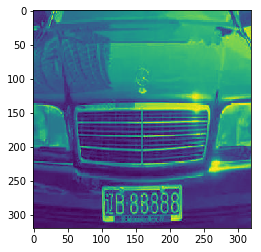

In [28]:
plt.imshow(X_train[1000])

In [ ]:
index = 0
for i in range(20):
    index = i * 3 + index
    y = Y_train[index]
    x = np.reshape(X_train[index], (1, 320, 320))
    y_predict = build_model.predict(x)
    y_predict = y_predict.reshape((7,))
#     y_label = utils.getLabel(root, filename, y)
#     y_predict_label = utils.getLabel(root, filename, np.absolute(y_predict))
#     print('label:' + str(y_label) + ',' + 'predict_label:' + str(y_predict_label))
#     print(y_predict)
    print('label:' + str(y) + ',' + 'predict_label:' + str(np.absolute(y_predict).astype('int')))

label:[18 41 31 31 35 36 32],predict_label:[13 42 34 29 30 34 33]
label:[18 41 37 31 36 48 64],predict_label:[19 49 41 33 39 45 55]
label:[18 44 36 36 34 36 36],predict_label:[14 46 40 36 34 36 38]
label:[18 46 46 43 33 33 34],predict_label:[18 45 44 38 35 32 32]
label:[ 9 41 31 31 31 31 32],predict_label:[ 8 41 33 29 28 32 31]
label:[ 9 41 47 37 32 31 35],predict_label:[13 44 44 34 30 28 34]
label:[ 9 47 51 63 38 36 32],predict_label:[14 54 54 57 36 35 37]
label:[ 9 54 65 47 40 31 40],predict_label:[ 9 49 57 43 38 33 37]
label:[ 0 41 39 39 39 39 39],predict_label:[ 0 47 41 38 39 39 38]
label:[ 0 45 63 55 40 32 32],predict_label:[ 1 44 58 44 39 28 31]
label:[ 6 42 39 39 39 39 39],predict_label:[ 9 42 38 36 34 34 37]
label:[17 41 51 53 31 37 36],predict_label:[18 45 51 42 32 38 40]
label:[17 46 33 42 40 35 36],predict_label:[18 48 33 39 37 34 36]
label:[ 5 42 38 31 39 39 32],predict_label:[ 8 45 36 32 35 34 33]
label:[28 41 45 39 31 31 31],predict_label:[23 40 42 33 30 26 30]
label:[30 